In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import os
import gc
import re
import json
import shutil
import zipfile
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry.polygon import orient
from shapely.geometry import Polygon, mapping
from xml.etree import ElementTree as ET
from icelakes.utilities import get_size

from icelakes.utilities import encedc, decedc, get_size
from icelakes.nsidc import download_granule, edc
from icelakes.detection import read_atl03, detect_lakes, melt_lake

import time
import io

In [415]:
################################################################################
def plot_geojsons_for_query(searchfor, gjsn_dir='geojsons'):
    dpi = 100
    if 'ANT_' in searchfor:
        dpi = 300
    fig, ax = plt.subplots(dpi=dpi)
    gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
                if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
    for i, gjsn in enumerate(gjsn_list):
        gdf = gpd.read_file(gjsn.replace('simplified_', ''))
        gdf.plot(color='C%i' % i, alpha=0.2, ax=ax)
        gdf.exterior.plot(color='r', lw=0.5, ax=ax)
        gdf = gpd.read_file(gjsn)
        gdf.exterior.plot(color='k', lw=0.5, ax=ax)
    ax.set_title('geojsons used for: %s' % searchfor)
    plt.close(fig)
    display(fig)
    return fig

################################################################################
def make_async_request(short_name='ATL03', start_date='2018-01-01', end_date='2030-01-01', uid=None, pwd=None, rgt='all', gtxs='all',
                       boundbox=None, shape=None, vars_sub='default', output_dir='nsidc_outputs', start_time='00:00:00', end_time='23:59:59',
                       spatial_sub=True):

    if (not uid) or (not pwd):
        uid = decedc(edc().u)
        pwd = decedc(edc().p)
    
    bounding_box = '' if not boundbox else '%.7f,%.7f,%.7f,%.7f' % tuple(boundbox)
    temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
    
    cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
    granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
    base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'
    
    # Get json response from CMR collection metadata
    params = {'short_name': short_name}
    response = requests.get(cmr_collections_url, params=params)
    results = json.loads(response.content)
    
    # Find all instances of 'version_id' in metadata and print most recent version number
    versions = [el['version_id'] for el in results['feed']['entry']]
    latest_version = max(versions)
    capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'
    
    search_params = {'short_name': short_name, 'version': latest_version, 'temporal': temporal, 'page_size': 2000, 'page_num': 1}
    if boundbox is not None: search_params['bounding_box'] = bounding_box
    elif shape is not None: 
        geojson_filepath = str('geojsons/' + shape)
        gdf = gpd.read_file(geojson_filepath)
        poly = orient(gdf.loc[0].geometry,sign=1.0)
        geojson_data = gpd.GeoSeries(poly).to_json() # Convert to geojson
        geojson_data = geojson_data.replace(' ', '') #remove spaces for API call
        
        #Format dictionary to polygon coordinate pairs for CMR polygon filtering
        polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
        
        print('\nInput geojson:', shape)
        print('Simplified polygon coordinates based on geojson input:', polygon)
        search_params['polygon'] = polygon
        
    else: print('No spatial filtering criteria were given.')
    
    headers= {'Accept': 'application/json'}
    print("Search parameters:", search_params)
    
    # query for granules 
    granules = []
    headers={'Accept': 'application/json'}
    while True:
        response = requests.get(granule_search_url, params=search_params, headers=headers)
        results = json.loads(response.content)
        if len(results['feed']['entry']) == 0: break
        granules.extend(results['feed']['entry'])
        search_params['page_num'] += 1
        
    if not (rgt=='all'):
        granules = [g for g in granules if g['producer_granule_id'][21:25] == '%04i'%rgt]
        
    granule_list, idx_unique = np.unique(np.array([g['producer_granule_id'] for g in granules]), return_index=True)
    granules = [g for i,g in enumerate(granules) if i in idx_unique]
    
    print('\nFound %i %s version %s granules over the search area between %s and %s.' % (len(granules), short_name, latest_version, 
                                                                              start_date, end_date))
    if len(granules) == 0: print('None')
    for result in granules[:np.min((5,len(granules)))]:
        print('  '+result['producer_granule_id'], f', {float(result["granule_size"]):.2f} MB',sep='')
    if len(granules) > 5:
        print('  ...and %i more results.' % (len(granules)-5))
    
    # Create session to store cookie and pass credentials to capabilities url
    session = requests.session()
    s = session.get(capability_url)
    response = session.get(s.url,auth=(uid,pwd))
    
    root = ET.fromstring(response.content)
    
    #collect lists with each service option
    subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
    
    # this is for getting possible variable values from the granule search
    if len(subagent) > 0 :
        # variable subsetting
        variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
        variables_raw = [variables[i]['value'] for i in range(len(variables))]
        variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
        variable_vals = [v.replace(':', '/') for v in variables_join]
    
    # make sure to only request the variables that are available
    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3
    
    # set the variables for subsetting
    if vars_sub == 'all':
        var_list_subsetting = ''
    else:
        if vars_sub == 'default':
            vars_sub = ['/ancillary_data/atlas_sdp_gps_epoch',
                        '/ancillary_data/calibrations/dead_time/gtx',
                        '/orbit_info/rgt',
                        '/orbit_info/cycle_number',
                        '/orbit_info/sc_orient',
                        '/gtx/geolocation/segment_id',
                        '/gtx/geolocation/ph_index_beg',
                        '/gtx/geolocation/segment_dist_x',
                        '/gtx/geolocation/segment_length',
                        '/gtx/geolocation/segment_ph_cnt',
                        '/gtx/geophys_corr/geoid',
                        '/gtx/bckgrd_atlas/pce_mframe_cnt',
                        '/gtx/bckgrd_atlas/tlm_height_band1',
                        '/gtx/bckgrd_atlas/tlm_height_band2',
                        '/gtx/bckgrd_atlas/tlm_top_band1',
                        '/gtx/bckgrd_atlas/tlm_top_band2',
                        '/gtx/heights/lat_ph',
                        '/gtx/heights/lon_ph',
                        '/gtx/heights/h_ph',
                        '/gtx/heights/delta_time',
                        '/gtx/heights/dist_ph_along',
                        '/gtx/heights/quality_ph',
                        '/gtx/heights/pce_mframe_cnt',
                        '/gtx/heights/ph_id_pulse'
                        ]
        beam_list = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
        if gtxs == 'all':
            var_list = sum([[v.replace('/gtx','/'+bm) for bm in beam_list] if '/gtx' in v else [v] for v in vars_sub],[])
        elif type(gtxs) == str:
            var_list = [v.replace('/gtx','/'+gtxs.lower()) if '/gtx' in v else v for v in vars_sub]
        elif type(gtxs) == list:
            var_list = sum([[v.replace('/gtx','/'+bm.lower()) for bm in gtxs] if '/gtx' in v else [v] for v in vars_sub],[])
        else: # default to requesting all beams
            var_list = sum([[v.replace('/gtx','/'+bm) for bm in beam_list] if '/gtx' in v else [v] for v in vars_sub],[])
        var_list_subsetting = ','.join(var_list)
    
    # set the request parameters
    if len(subagent) < 1 :
        print('No services exist for', short_name, 'version', latest_version)
        agent = 'NO'
        coverage,Boundingshape,polygon = '','',''
    else:
        agent = ''
        subdict = subagent[0]
        if (subdict['spatialSubsettingShapefile'] == 'true') and spatial_sub:
            if shape:
                Boundingshape, bbox, bounding_box = polygon, '', ''
            else:
                Boundingshape, polygon = '', ''
        else:
            Boundingshape, polygon = '',''
        coverage = var_list_subsetting
    if (vars_sub=='all') & (not spatial_sub):
        agent = 'NO'
    
    # Set request mode to asynchronous
    request_mode = 'async'
    page_size = 2000
    # Determine number of orders needed for requests over 2000 granules. 
    page_num = int(np.ceil(len(granules)/page_size))
    
    print('  --> There will be', page_num, 'total order(s) processed for your', short_name, 'request.')
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'bbox': bbox,
                  'bounding_box': bounding_box,
                  'Boundingshape': Boundingshape, 
                  'polygon': polygon,
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': 'no', }
    
    # Remove blank key-value-pairs
    param_dict = {k: v for k, v in param_dict.items() if v != ''}
    
    # Convert to string
    param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
    param_string = param_string.replace("'","")
    
    # Print API base URL + request parameters
    endpoint_list = [] 
    for i in range(page_num):
        page_val = i + 1
        API_request = f'{base_url}?{param_string}&page_num={page_val}'
        endpoint_list.append(API_request)
    
    print('\n', *endpoint_list, sep = "\n") 
    
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
    
        # For all requests other than spatial file upload, use get function
        param_dict['page_num'] = page_val
        request = session.get(base_url, params=param_dict)
    
        print('Request HTTP response: ', request.status_code)
    
        # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        # print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        # print('Order request response XML content: ', request.content)
    
        #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)
    
        #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)
    
        #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)
    
        # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)
    
    return statusURL, len(granules), request_response.status_code


def filter_release(df_in):
    # there should not be any, but to make sure drop any duplicates
    df = df_in.copy()
    df = df.drop_duplicates(ignore_index=True)
    
    # keep only the latest release of each granule (relevant during ITRF reprocessing, etc.)
    df['release'] = df.apply(lambda x: int(x.granule.split('_')[-1][:2]), axis=1)
    df['version'] = df.apply(lambda x: int(x.granule.split('_')[3]), axis=1)
    df['ttttccnn'] = df.apply(lambda x: int(x.granule.split('_')[2]), axis=1)
    
    # make id for granule / region combination
    df['granule_region_id'] = df.apply(lambda x: str(x.ttttccnn) + x.geojson_clip, axis=1)
    df_maxversion = df.groupby(by='granule_region_id')[['version']].max().rename(columns={'version': 'version_max'})
    df['select'] = df.apply(lambda x: x.version == df_maxversion.loc[x.granule_region_id].version_max, axis=1)
    df = df[df.select]
    df_maxrelease = df.groupby(by='granule_region_id')[['release']].max().rename(columns={'release': 'release_max'})
    df['select'] = df.apply(lambda x: x.release == df_maxrelease.loc[x.granule_region_id].release_max, axis=1)
    df = df[df.select]

    return df


def write_granule_list(input_list):
    df = pd.read_csv(input_list, header=None, names=['fn','hold_reason'])
    df['is_memory'] = df.apply(lambda x: 'exceeded request_memory' in x.hold_reason, axis=1)
    df['granule'] = df.apply(lambda x: x.fn[x.fn.find('ATL03_'):x.fn.find('.h5')+3], axis=1)
    def get_description(x):
        substr = x.fn[x.fn.find('job_')+4:x.fn.find('_ATL03_')]
        return substr[:substr.rfind('-')]
    df['description'] = df.apply(get_description, axis=1)
    def get_geojson(x):
        parms = x.description.split('_')
        parms[0] = 'ANT' if parms[0] == 'AIS' else 'GRE'
        del parms[1]
        return 'geojsons/simplified_' + '_'.join(parms) + '.geojson'
    df['geojson'] = df.apply(get_geojson, axis=1)
    df['geojson_full'] = df.apply(lambda x: x.geojson.replace('simplified_', ''), axis=1)
    df = df[['granule','geojson','description','geojson_full','fn','hold_reason','is_memory']]
    df.to_csv(input_list.replace('.csv', '_processed.csv'))
    
    df_mem = df[df.is_memory]
    df_nomem = df[~df.is_memory]
    
    df_mem = df_mem.drop(columns=['fn','hold_reason','is_memory'])
    df_nomem = df_nomem.drop(columns=['fn','hold_reason','is_memory'])
    
    fn_mem = input_list.replace('hold_lists/', 'granule_lists/').replace('final_', 'memory_')
    fn_nomem = input_list.replace('hold_lists/', 'granule_lists/').replace('final_', 'resubmit_')
    
    df_mem.to_csv(fn_mem, header=False, index=False)
    print('Wrote file %s. (%i jobs)' % (fn_mem, len(df_mem)))
    df_nomem.to_csv(fn_nomem, header=False, index=False)
    print('Wrote file %s. (%i jobs)' % (fn_nomem, len(df_nomem)))

    return fn_mem, fn_nomem


def write_submit_file(list_fn, sub_fn=None, mem_gb=16, resource_adjust=False, stream_error=False, stream_output=False): 
    if not sub_fn:
        sub_fn = list_fn.replace('granule_lists/', 'HTCondor_submit/').replace('.csv', '.submit')
    
    f = open(sub_fn, "w")
    print('universe    = vanilla', file=f)
    print('+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"', file=f)
    print('Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000', file=f)
    print('executable  = run_py.sh', file=f)
    print('arguments = $(granule_url) $(polygon)', file=f)
    print('max_retries = 30', file=f)
    print('success_exit_code = 69', file=f)
    print('transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)', file=f)
    print('transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat', file=f)
    print('should_transfer_files = YES', file=f)
    print('when_to_transfer_output = ON_EXIT', file=f)
    print('periodic_release = (HoldReasonCode == 13)', file=f)
    print('log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log', file=f)
    print('error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err', file=f)
    print('output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out', file=f)
    if stream_error:
        print('stream_error = True', file=f)
    if stream_output:
        print('stream_output = True', file=f)
    print('request_cpus    = 1', file=f)
    if resource_adjust:
        print('request_memory  = $(mem_request)', file=f)
        print('request_disk    = $(dsk_request)', file=f)
        print('queue granule_url,granule_id,polygon,descriptor,polygon_full,mem_request,dsk_request from %s' % list_fn, file=f)
    else:
        print('request_memory  = %iGB' % mem_gb, file=f)
        print('request_disk    = %iGB' % mem_gb, file=f)
        print('queue granule_url,granule_id,polygon,descriptor,polygon_full from %s' % list_fn, file=f)
    f.close()
    
    print('Wrote file %s.\n' % sub_fn)
    return sub_fn


# Run the following to initialize the dataframe with NSIDC requests parameters

____________________________________________________________________________
GREENLAND 2019-23
____________________________________________________________________________


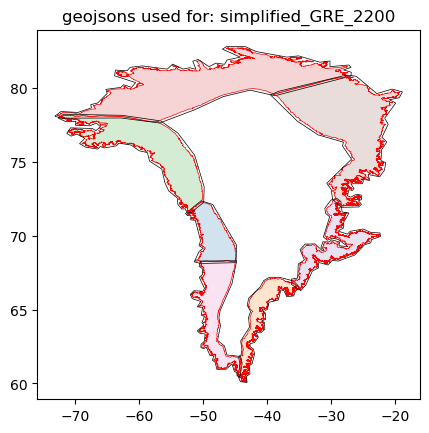

____________________________________________________________________________
ANTARCTICA - GLD3 (2018-19 to 2022-23)
____________________________________________________________________________


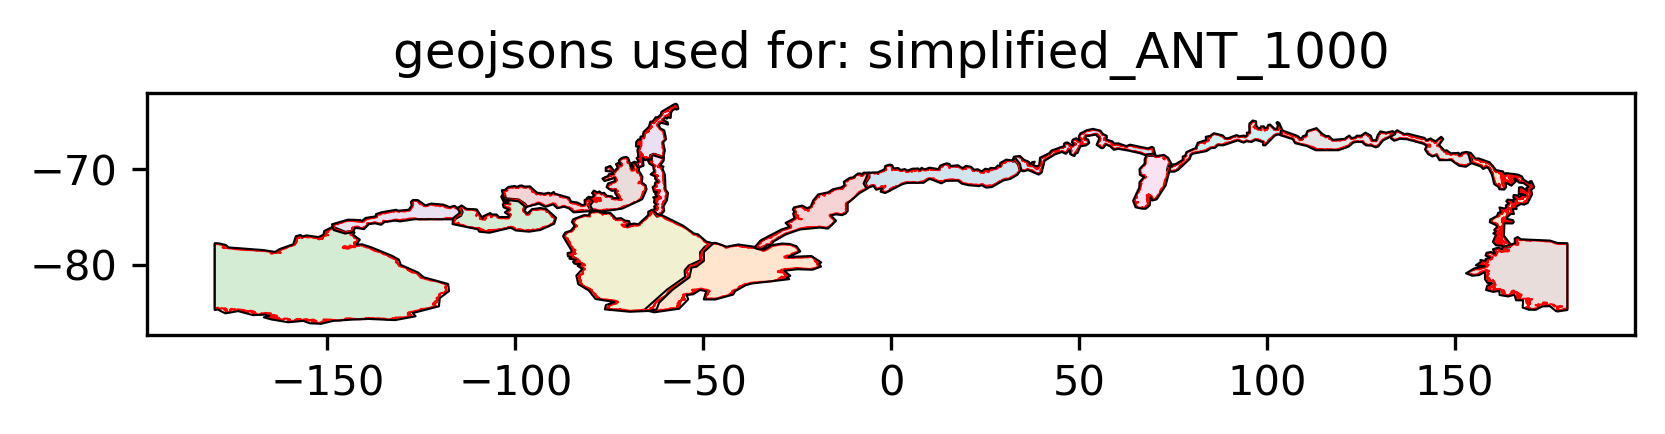

,ice_sheet,melt_season,geojson,start_date,end_date,status_url,ngranules_request,request_code
0,GrIS,2019,simplified_GRE_2200_CW.geojson,2019-05-01,2019-09-30,-1,-1,-1
1,GrIS,2020,simplified_GRE_2200_CW.geojson,2020-05-01,2020-09-30,-1,-1,-1
2,GrIS,2021,simplified_GRE_2200_CW.geojson,2021-05-01,2021-09-30,-1,-1,-1
3,GrIS,2022,simplified_GRE_2200_CW.geojson,2022-05-01,2022-09-30,-1,-1,-1
4,GrIS,2023,simplified_GRE_2200_CW.geojson,2023-05-01,2023-09-30,-1,-1,-1
...,...,...,...,...,...,...,...,...
120,AIS,2018-19,simplified_ANT_1000_East_Cp-D.geojson,2018-11-01,2019-03-31,-1,-1,-1
121,AIS,2019-20,simplified_ANT_1000_East_Cp-D.geojson,2019-11-01,2020-03-31,-1,-1,-1
122,AIS,2020-21,simplified_ANT_1000_East_Cp-D.geojson,2020-11-01,2021-03-31,-1,-1,-1
123,AIS,2021-22,simplified_ANT_1000_East_Cp-D.geojson,2021-11-01,2022-03-31,-1,-1,-1


In [11]:
outdict = {
    'ice_sheet': [],
    'melt_season': [],
    'geojson': [],
    'start_date': [],
    'end_date': []
}

############################################################
# GREENLAND - GLD3
startyear = 2019
endyear = 2023
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2200'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND 2019-23')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outdict['ice_sheet'].append(icesheet)
        outdict['melt_season'].append(meltseason)
        outdict['geojson'].append(geojson)
        outdict['start_date'].append(start_date)
        outdict['end_date'].append(end_date)

############################################################
# ANTARCTICA - GLD3
startyear = 2018
endyear = 2023
startday = '11-01'
endday = '03-31'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('ANTARCTICA - GLD3 (2018-19 to 2022-23)')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outdict['ice_sheet'].append(icesheet)
        outdict['melt_season'].append(meltseason)
        outdict['geojson'].append(geojson)
        outdict['start_date'].append(start_date)
        outdict['end_date'].append(end_date)

df = pd.DataFrame(outdict)

df['status_url'] = -1
df['ngranules_request'] = -1
df['request_code'] = -1

fn_requests = 'nsidc_requests/gld3_request_params.csv'
df.to_csv(fn_requests, header=True, index=False)

df = pd.read_csv(fn_requests)
df

# Run the following until all requests have been submitted 

In [224]:
fn_working = 'nsidc_requests/gld3_status_urls_working.csv'
if os.path.isfile(fn_working):
    df = pd.read_csv(fn_working)
else:
    df = pd.read_csv(fn_requests)

for i in list(df.index):
    row = df.loc[i]
    shape = row.geojson
    start_date = row.start_date
    end_date = row.end_date
    ice_sheet = row.ice_sheet
    melt_season = row.melt_season
    status_url = row.status_url
    if status_url != '-1':
        print('already submitted', ice_sheet, melt_season, shape, '(', i+1, '/', len(df), ')')
    else:
        print('\n________________________________________________________________________________')
        print('submitting', ice_sheet, melt_season, shape, '(', i+1, '/', len(df), ')')
        
        status_url, ngranules, status_code = make_async_request(short_name='ATL03', start_date=start_date, end_date=end_date, shape=shape)

        df.loc[i, 'status_url'] = status_url
        df.loc[i, 'request_code'] = status_code
        df.loc[i, 'ngranules_request'] = ngranules
        
        print('\n________________________________________________________________________________')

df.to_csv(fn_working, header=True, index=False)

df = pd.read_csv(fn_statusurls)
df

already processed GrIS 2019 simplified_GRE_2200_CW.geojson ( 1 / 125 )
already processed GrIS 2020 simplified_GRE_2200_CW.geojson ( 2 / 125 )
already processed GrIS 2021 simplified_GRE_2200_CW.geojson ( 3 / 125 )
already processed GrIS 2022 simplified_GRE_2200_CW.geojson ( 4 / 125 )
already processed GrIS 2023 simplified_GRE_2200_CW.geojson ( 5 / 125 )
already processed GrIS 2019 simplified_GRE_2200_SE.geojson ( 6 / 125 )
already processed GrIS 2020 simplified_GRE_2200_SE.geojson ( 7 / 125 )
already processed GrIS 2021 simplified_GRE_2200_SE.geojson ( 8 / 125 )
already processed GrIS 2022 simplified_GRE_2200_SE.geojson ( 9 / 125 )
already processed GrIS 2023 simplified_GRE_2200_SE.geojson ( 10 / 125 )
already processed GrIS 2019 simplified_GRE_2200_NW.geojson ( 11 / 125 )
already processed GrIS 2020 simplified_GRE_2200_NW.geojson ( 12 / 125 )
already processed GrIS 2021 simplified_GRE_2200_NW.geojson ( 13 / 125 )
already processed GrIS 2022 simplified_GRE_2200_NW.geojson ( 14 / 125 )
a

,ice_sheet,melt_season,geojson,start_date,end_date,status_url,request_code,ngranules_request
0,GrIS,2019,simplified_GRE_2200_CW.geojson,2019-05-01,2019-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,98
1,GrIS,2020,simplified_GRE_2200_CW.geojson,2020-05-01,2020-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,110
2,GrIS,2021,simplified_GRE_2200_CW.geojson,2021-05-01,2021-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,108
3,GrIS,2022,simplified_GRE_2200_CW.geojson,2022-05-01,2022-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,109
4,GrIS,2023,simplified_GRE_2200_CW.geojson,2023-05-01,2023-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,107
...,...,...,...,...,...,...,...,...
120,AIS,2018-19,simplified_ANT_1000_East_Cp-D.geojson,2018-11-01,2019-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,378
121,AIS,2019-20,simplified_ANT_1000_East_Cp-D.geojson,2019-11-01,2020-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,398
122,AIS,2020-21,simplified_ANT_1000_East_Cp-D.geojson,2020-11-01,2021-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,385
123,AIS,2021-22,simplified_ANT_1000_East_Cp-D.geojson,2021-11-01,2022-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,390


# Make sure all requests have an initial 201 status code

In [560]:
np.unique(df.request_code)

array([201])

In [561]:
# total number of granules
df.ngranules_request.sum()

54056

# Now run the following to get the info from the status URLs and run this until all requests at NSIDC have completed

In [559]:
df = pd.read_csv(fn_statusurls)

# #### to get the credentials into the session
# #### need to run if re-starting the kernel 
if not session:
    # uid = decedc(edc().u)
    # pwd = decedc(edc().p)
    # capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.006.xml'
    # session = requests.session()
    # s = session.get(capability_url)
    # response = session.get(s.url,auth=(uid,pwd))

df['description'] = df.apply(lambda x: '%s_%s_%s' % (x.ice_sheet, x.melt_season, '_'.join(x.geojson.split('_')[2:]).replace('.geojson','')), axis=1)
df['basin'] = df.apply(lambda x: '_'.join(x.description.split('_')[3:]), axis=1)
df['status'] = ''
df['orderID'] = ''
df['status_txt'] = -1
df['nprocessed'] = 0
df['n_links'] = 0
df['gran_list_url'] = ''
df['order_overview_url'] = ''
df['order_summary_url'] = ''
df['available_until'] = ''

for i in list(df.index):
    n_links = 0
    status_txt = -1
    gran_list_url = ''
    order_overview_url = ''
    order_summary_url = ''
    
    statusURL = df.loc[i,'status_url']
    
    #Find order status
    request_response = session.get(statusURL)
    status_code = request_response.status_code

    # Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    nprocessed = int(statuslist[1])
    
    orderlist = []
    for order in request_root.findall("./order/"):
        orderlist.append(order.text)
    instructions = orderlist[1]
    orderID = orderlist[0]
    available_until = instructions[instructions.rfind('URLs until ')+len('URLs until '):-7] if 'You may retrieve the results' in instructions else 'not yet available'

    if (status == 'complete') or (status == 'complete_with_errors'):
        order_overview_url = 'https://n5eil02u.ecs.nsidc.org/esir/%s.html' % orderID
        gran_list_url = 'https://n5eil02u.ecs.nsidc.org/esir/%s.txt' % orderID
        order_summary_url = 'https://n5eil02u.ecs.nsidc.org/esir/%s/requestSummary.txt' % orderID
        gran_list_file = session.get(gran_list_url)
        status_txt = int(gran_list_file.status_code)
        gran_list = gran_list_file.content.decode('utf-8').split('\n')
        gran_list = [x for x in gran_list if '.h5' in x]
        n_links = len(gran_list)

    df.loc[i, 'status'] = status
    df.loc[i, 'orderID'] = orderID
    df.loc[i, 'status_txt'] = status_txt
    df.loc[i, 'nprocessed'] = nprocessed
    df.loc[i, 'n_links'] = n_links
    df.loc[i, 'gran_list_url'] = gran_list_url
    df.loc[i, 'order_overview_url'] = order_overview_url
    df.loc[i, 'order_summary_url'] = order_summary_url
    df.loc[i, 'available_until'] = available_until

    n_missing = nprocessed - df.loc[i, 'n_links']
    if status == 'processing':
        n_missing = 0
    n_missing_str = '' if n_missing == 0 else ' ---> %i missing' % n_missing
    print('%3i / %3i : %4s, %7s, %15s --> %20s (%4i / %4i, %4i links)%s' % (i+1, len(df), df.loc[i, 'ice_sheet'], df.loc[i, 'melt_season'], 
          df.loc[i, 'basin'], status, nprocessed, df.loc[i, 'ngranules_request'], df.loc[i, 'n_links'], n_missing_str))

print('\n_____________________________________________________________________\n')
print('%.0f%% of granules processed at NSIDC (%i / %i)\n' % (df.nprocessed.sum() / df.ngranules_request.sum() * 100, df.nprocessed.sum(), df.ngranules_request.sum()))

fn_order_info_progress = 'nsidc_requests/gld3_order_info_complete.csv' if np.sum(df.status == 'complete') == len(df) else 'nsidc_requests/gld3_order_info_progress.csv'
df.to_csv(fn_order_info_progress, header=True, index=False)
display(df)

print('\nnumber of granules:'.upper())
print('  Greenland:  %5i total | %5i processed | %5i links' % (df.ngranules_request[df.ice_sheet=='GrIS'].sum(), 
                                                              df.nprocessed[df.ice_sheet=='GrIS'].sum(),
                                                              df.n_links[df.ice_sheet=='GrIS'].sum()))
print('  Antarctica: %5i total | %5i processed | %5i links' % (df.ngranules_request[df.ice_sheet=='AIS'].sum(),
                                                               df.nprocessed[df.ice_sheet=='AIS'].sum(),
                                                               df.n_links[df.ice_sheet=='AIS'].sum()))

  1 / 125 : GrIS,    2019,              CW -->             complete (  98 /   98,   98 links)
  2 / 125 : GrIS,    2020,              CW -->             complete ( 110 /  110,  110 links)
  3 / 125 : GrIS,    2021,              CW -->             complete ( 108 /  108,  108 links)
  4 / 125 : GrIS,    2022,              CW -->             complete ( 109 /  109,  109 links)
  5 / 125 : GrIS,    2023,              CW -->             complete ( 107 /  107,  107 links)
  6 / 125 : GrIS,    2019,              SE -->             complete ( 116 /  116,  116 links)
  7 / 125 : GrIS,    2020,              SE -->             complete ( 134 /  134,  134 links)
  8 / 125 : GrIS,    2021,              SE -->             complete ( 133 /  133,  133 links)
  9 / 125 : GrIS,    2022,              SE -->             complete ( 133 /  133,  133 links)
 10 / 125 : GrIS,    2023,              SE -->             complete ( 130 /  130,  130 links)
 11 / 125 : GrIS,    2019,              NW -->             c

,ice_sheet,melt_season,geojson,start_date,end_date,status_url,request_code,ngranules_request,description,basin,status,orderID,status_txt,nprocessed,n_links,gran_list_url,order_overview_url,order_summary_url,available_until
0,GrIS,2019,simplified_GRE_2200_CW.geojson,2019-05-01,2019-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,98,GrIS_2019_2200_CW,CW,complete,5000005624133,200,98,98,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
1,GrIS,2020,simplified_GRE_2200_CW.geojson,2020-05-01,2020-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,110,GrIS_2020_2200_CW,CW,complete,5000005624134,200,110,110,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:41
2,GrIS,2021,simplified_GRE_2200_CW.geojson,2021-05-01,2021-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,108,GrIS_2021_2200_CW,CW,complete,5000005624135,200,108,108,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:56
3,GrIS,2022,simplified_GRE_2200_CW.geojson,2022-05-01,2022-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,109,GrIS_2022_2200_CW,CW,complete,5000005624136,200,109,109,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 17:02
4,GrIS,2023,simplified_GRE_2200_CW.geojson,2023-05-01,2023-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,107,GrIS_2023_2200_CW,CW,complete,5000005624137,200,107,107,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 17:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AIS,2018-19,simplified_ANT_1000_East_Cp-D.geojson,2018-11-01,2019-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,378,AIS_2018-19_1000_East_Cp-D,East_Cp-D,complete,5000005624282,200,378,378,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 06:59
121,AIS,2019-20,simplified_ANT_1000_East_Cp-D.geojson,2019-11-01,2020-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,398,AIS_2019-20_1000_East_Cp-D,East_Cp-D,complete,5000005624283,200,398,398,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:09
122,AIS,2020-21,simplified_ANT_1000_East_Cp-D.geojson,2020-11-01,2021-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,385,AIS_2020-21_1000_East_Cp-D,East_Cp-D,complete,5000005624284,200,385,385,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:21
123,AIS,2021-22,simplified_ANT_1000_East_Cp-D.geojson,2021-11-01,2022-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,390,AIS_2021-22_1000_East_Cp-D,East_Cp-D,complete,5000005624285,200,390,390,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:3



NUMBER OF GRANULES:
  Greenland:  11304 total | 11304 processed | 11303 links
  Antarctica: 42752 total | 42752 processed | 42747 links


# Keep track of the (hopefully few) granules that had errors when processing at NSIDC, and run these later 
Assuming it's just a few, we can do this later locally.

In [632]:
df = pd.read_csv(fn_order_info_progress)
dferr = df[df.status == 'complete_with_errors']

missing_dict = {'granule_missing': [], 'polygon_missing': []}
for i in dferr.index:
    summaryURL = df.loc[i].order_summary_url
    request_response = session.get(summaryURL)
    status_code = request_response.status_code
    polygon = df.loc[i].geojson

    # Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    txt = request_response.content.decode('utf-8')

    # find the missing granules
    txt_in = txt[txt.find('"inputFiles" : ['):]
    txt_in = txt_in[:txt_in.find('  ],')]
    files_in = txt_in.replace('\n','').replace('"','').replace('inputFiles : [', '').split(',')
    files_in = [x.strip() for x in files_in]
    txt_out = txt[txt.find('"outputFiles" : ['):]
    txt_out = txt_out[:txt_out.find('  ],')]
    files_out = txt_out.replace('\n','').replace('"','').replace('outputFiles : [', '').split(',')
    files_out = [x.strip().replace('processed_', '') for x in files_out]
    files_missing = list(set(files_in) - set(files_out))

    for j in range(len(files_missing)):
        missing_dict['granule_missing'].append(files_missing[j])
        missing_dict['polygon_missing'].append(polygon)

df_missing = pd.DataFrame(missing_dict)
df_missing.to_csv('granule_lists/GLD3-NSIDC-processing-errors.csv')

print('')
print('granule_missing,polygon_missing')
for i in df_missing.index:
    print('%s,%s' % (df_missing.loc[i].granule_missing, df_missing.loc[i].polygon_missing))
print('')

df_missing


granule_missing,polygon_missing
ATL03_20200911210344_11990805_006_02.h5,simplified_GRE_2200_NE.geojson
ATL03_20201218221710_13090911_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
ATL03_20201224211732_00131011_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
ATL03_20210102220932_01511011_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
ATL03_20201224225149_00141011_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
ATL03_20201220230009_13400911_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson



,granule_missing,polygon_missing
0,ATL03_20200911210344_11990805_006_02.h5,simplified_GRE_2200_NE.geojson
1,ATL03_20201218221710_13090911_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
2,ATL03_20201224211732_00131011_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
3,ATL03_20210102220932_01511011_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
4,ATL03_20201224225149_00141011_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson
5,ATL03_20201220230009_13400911_006_01.h5,simplified_ANT_1000_West_Ep-F.geojson


# Now make the actual granule lists

In [595]:
from IPython.display import display, Markdown

df = pd.read_csv(fn_order_info_progress)

outdir = 'granule_lists/'
outinfo = {
    'Greenland 2019 to 2023': 'GLD3-GRE-0.csv', 
    'Antarctica 2018-19 and 2019-20': 'GLD3-ANT_1-0.csv',
    'Antarctica 2020-21 and 2021-22': 'GLD3-ANT_2-0.csv',
    'Antarctica 2022-23': 'GLD3-ANT_3-0.csv',
}

for description, outname in outinfo.items():
    
    if description == 'Greenland 2019 to 2023':
        df_complete = df[df.ice_sheet == 'GrIS']
    elif description == 'Antarctica 2018-19 and 2019-20':
        df_complete = df[(df.ice_sheet == 'AIS') & ((df.melt_season == '2018-19') | (df.melt_season == '2019-20'))]
    elif description == 'Antarctica 2020-21 and 2021-22':
        df_complete = df[(df.ice_sheet == 'AIS') & ((df.melt_season == '2020-21') | (df.melt_season == '2021-22'))]
    elif description == 'Antarctica 2022-23':
        df_complete = df[(df.ice_sheet == 'AIS') & (df.melt_season == '2022-23')]
    else:
        print('Not all descriptions for granule lists are matching! Please check that this is correct!')
        break

    display(Markdown('# %s' % description))

    outpath = outdir + outname
    
    # #### to get the credentials into the session
    if not session:
        uid = decedc(edc().u)
        pwd = decedc(edc().p)
        capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.006.xml'
        session = requests.session()
        s = session.get(capability_url)
        response = session.get(s.url,auth=(uid,pwd))
        
    def get_request_memory(x):
        req = 4000 + (30000-4000) / 2000 * x
        return '%sMB' % int(np.ceil(np.clip(req, 0, 64000)))
    
    def get_request_disk(x):
        req = 2e6 + (6e6-2e6) / 1500 * x
        return '%sKB' % int(np.ceil(np.clip(req, 0, 32e6)))
    
    df_list = []
    for i in list(df_complete.index):
        gran_list_url = df_complete.loc[i, 'gran_list_url']
        gran_list_file = session.get(gran_list_url)
        status_txt = int(gran_list_file.status_code)
        gran_list = gran_list_file.content.decode('utf-8').split('\n')
        gran_list = [x for x in gran_list if '.h5' in x]
        order_overview_url = df_complete.loc[i, 'order_overview_url']
        gran_list_html = session.get(order_overview_url)
        gran_list_html_txt = gran_list_html.content.decode('utf-8')
        starts = [m.end() for m in re.finditer(re.escape(".h5</a> ("), gran_list_html_txt)]
        ends = [m.start() for m in re.finditer(re.escape(", SCIENCE, content/unknown)"), gran_list_html_txt)]
        size_strs = [gran_list_html_txt[starts[j]:ends[j]] for j in range(len(starts))]
        sizes = [float(x[:-3].replace('<', '')) for x in size_strs]
        
        thisdf = pd.DataFrame({'granule_url': gran_list})
        thisdf['granule_id'] = thisdf.apply(lambda x: x.granule_url.split('/')[-1].replace('processed_','').replace('.h5',''), axis=1)
        thisdf['polygon'] = 'geojsons/' + df_complete.loc[i, 'geojson']
        thisdf['descriptor'] = df_complete.loc[i, 'description']
        thisdf['polygon_full'] = 'geojsons/' + df_complete.loc[i, 'geojson'].replace('simplified_', '')
        thisdf['size_mb'] = sizes
        thisdf['mem_request'] = thisdf.size_mb.apply(get_request_memory)
        thisdf['dsk_request'] = thisdf.size_mb.apply(get_request_disk)
        for k in ['ice_sheet', 'basin', 'melt_season', 'start_date', 'end_date', 'orderID', 'status', 'ngranules_request', 'nprocessed',
                  'n_links', 'status_url', 'gran_list_url', 'order_overview_url', 'order_summary_url', 'available_until']:
            thisdf[k] = df_complete.loc[i, k]
        df_list.append(thisdf)
    
    df_all = pd.concat(df_list).reset_index(drop=True)
    df_all.to_csv(outdir + 'request_info_' + outname, header=True, index=False)
    dfout = df_all[['granule_url', 'granule_id', 'polygon', 'descriptor', 'polygon_full', 'mem_request', 'dsk_request']]
    dfout.to_csv(outpath, header=False, index=False)
    
    print('\nDataframe with all info:')
    display(df_all)
    print('\ntotal size: %.3g TB\n\n' % (df_all.size_mb.sum()/1e6))
    
    df_granlist = pd.read_csv(outpath, header=None)
    print('\nThe actual granule list for the job:')
    display(df_granlist)
    
    submit_filename = write_submit_file(outpath, resource_adjust=True)
    ! cat $submit_filename

    print('\n_________________________________________________________________________\n')

display(Markdown('# Results'))
print('')
dfs_all = []
for description, outname in outinfo.items():
    df_final = pd.read_csv(outdir + 'request_info_' + outname)
    dfs_all.append(df_final)
    print('%s:' % description)
    print('  Number of granules:   %i' % len(df_final))
    print('  Total size processed: %.2f TB' % (df_final.size_mb.sum() / 1e6))
    print('  All available until:  %s\n' % df_final.available_until.sort_values().reset_index(drop=True).loc[0])
df_all = pd.concat(dfs_all).reset_index(drop=True)
df_all.to_csv(outdir + 'request_info_GLD3_total.csv')
print('TOTAL:')
print('  Number of granules:   %i' % len(df_all))
print('  Total size processed: %.2f TB' % (df_all.size_mb.sum() / 1e6))
print('  All available until:  %s\n' % df_all.available_until.sort_values().reset_index(drop=True).loc[0])

# Greenland 2019 to 2023


Dataframe with all info:


,granule_url,granule_id,polygon,descriptor,polygon_full,size_mb,mem_request,dsk_request,ice_sheet,basin,...,orderID,status,ngranules_request,nprocessed,n_links,status_url,gran_list_url,order_overview_url,order_summary_url,available_until
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190916150733_12300405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,1209.51,19724MB,5225360KB,GrIS,CW,...,5000005624133,complete,98,98,98,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190908023918_11000403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,9.26,4121MB,2024694KB,GrIS,CW,...,5000005624133,complete,98,98,98,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920145914_12910405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,630.88,12202MB,3682347KB,GrIS,CW,...,5000005624133,complete,98,98,98,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190904153231_10470405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,246.47,7205MB,2657254KB,GrIS,CW,...,5000005624133,complete,98,98,98,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920021420_12830403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,267.98,7484MB,2714614KB,GrIS,CW,...,5000005624133,complete,98,98,98,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11298,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230627204002_01172005_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,486.25,10322MB,3296667KB,GrIS,SW,...,5000005624169,complete,114,114,114,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:04
11299,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230630205719_01632005_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,1315.93,21108MB,5509147KB,GrIS,SW,...,5000005624169,complete,114,114,114,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:04
11300,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230610213904_12451905_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,267.18,7474MB,2712480KB,GrIS,SW,...,5000005624169,complete,114,114,114,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.o


total size: 3.66 TB



The actual granule list for the job:


,0,1,2,3,4,5,6
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190916150733_12300405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,19724MB,5225360KB
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190908023918_11000403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,4121MB,2024694KB
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920145914_12910405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,12202MB,3682347KB
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190904153231_10470405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,7205MB,2657254KB
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920021420_12830403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,7484MB,2714614KB
...,...,...,...,...,...,...,...
11298,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230627204002_01172005_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,10322MB,3296667KB
11299,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230630205719_01632005_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,21108MB,5509147KB
11300,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230610213904_12451905_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,7474MB,2712480KB
11301,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230602215551_11231905_006_02,geojsons/simplified_GRE_2200_SW.geojson,GrIS_2023_2200_SW,geojsons/GRE_2200_SW.geojson,7634MB,2745334KB


Wrote file HTCondor_submit/GLD3-GRE-0.submit.

universe    = vanilla
+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"
Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000
executable  = run_py.sh
arguments = $(granule_url) $(polygon)
max_retries = 30
success_exit_code = 69
transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)
transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
periodic_release = (HoldReasonCode == 13)
log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log
error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err
output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out
request_cpus    = 1
request_memory  = $(mem_request)
r

# Antarctica 2018-19 and 2019-20


Dataframe with all info:


,granule_url,granule_id,polygon,descriptor,polygon_full,size_mb,mem_request,dsk_request,ice_sheet,basin,...,orderID,status,ngranules_request,nprocessed,n_links,status_url,gran_list_url,order_overview_url,order_summary_url,available_until
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181101213926_05230110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,52.37,4681MB,2139654KB,AIS,East_Ap-B,...,5000005624170,complete,480,480,480,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:35
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181102224807_05390110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,7.34,4096MB,2019574KB,AIS,East_Ap-B,...,5000005624170,complete,480,480,480,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:35
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181104233108_05700110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,31.59,4411MB,2084240KB,AIS,East_Ap-B,...,5000005624170,complete,480,480,480,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:35
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181103222228_05540110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,3.86,4051MB,2010294KB,AIS,East_Ap-B,...,5000005624170,complete,480,480,480,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:35
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181104215650_05690110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,5.86,4077MB,2015627KB,AIS,East_Ap-B,...,5000005624170,complete,480,480,480,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 10:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17130,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200327054052_00100712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,92.14,5198MB,2245707KB,AIS,East_Cp-D,...,5000005624283,complete,398,398,398,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:09
17131,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200327071510_00110712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,104.22,5355MB,2277920KB,AIS,East_Cp-D,...,5000005624283,complete,398,398,398,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:09
17132,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200329062352_00410712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,125.73,5635MB,2335280


total size: 4.46 TB



The actual granule list for the job:


,0,1,2,3,4,5,6
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181101213926_05230110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4681MB,2139654KB
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181102224807_05390110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4096MB,2019574KB
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181104233108_05700110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4411MB,2084240KB
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181103222228_05540110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4051MB,2010294KB
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20181104215650_05690110_006_02,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2018-19_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4077MB,2015627KB
...,...,...,...,...,...,...,...
17130,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200327054052_00100712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,5198MB,2245707KB
17131,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200327071510_00110712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,5355MB,2277920KB
17132,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200329062352_00410712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,5635MB,2335280KB
17133,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20200331070649_00720712_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2019-20_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,6013MB,2412827KB


Wrote file HTCondor_submit/GLD3-ANT_1-0.submit.

universe    = vanilla
+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"
Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000
executable  = run_py.sh
arguments = $(granule_url) $(polygon)
max_retries = 30
success_exit_code = 69
transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)
transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
periodic_release = (HoldReasonCode == 13)
log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log
error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err
output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out
request_cpus    = 1
request_memory  = $(mem_request)

# Antarctica 2020-21 and 2021-22


Dataframe with all info:


,granule_url,granule_id,polygon,descriptor,polygon_full,size_mb,mem_request,dsk_request,ice_sheet,basin,...,orderID,status,ngranules_request,nprocessed,n_links,status_url,gran_list_url,order_overview_url,order_summary_url,available_until
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201103130640_06160910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,99.79,5298MB,2266107KB,AIS,East_Ap-B,...,5000005624172,complete,484,484,484,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:16
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201103113222_06150910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,581.58,11561MB,3550880KB,AIS,East_Ap-B,...,5000005624172,complete,484,484,484,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:16
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201104124100_06310910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,401.44,9219MB,3070507KB,AIS,East_Ap-B,...,5000005624172,complete,484,484,484,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:16
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201102115803_06000910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,552.19,11179MB,3472507KB,AIS,East_Ap-B,...,5000005624172,complete,484,484,484,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:16
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201101122342_05850910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,208.22,6707MB,2555254KB,AIS,East_Ap-B,...,5000005624172,complete,484,484,484,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17103,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220323185949_00101512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,8.20,4107MB,2021867KB,AIS,East_Cp-D,...,5000005624285,complete,390,390,390,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:3
17104,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220328200009_00871512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,58.28,4758MB,2155414KB,AIS,East_Cp-D,...,5000005624285,complete,390,390,390,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:3
17105,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220323203406_00111512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,1.59,4021MB,2004


total size: 4.9 TB



The actual granule list for the job:


,0,1,2,3,4,5,6
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201103130640_06160910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,5298MB,2266107KB
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201103113222_06150910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,11561MB,3550880KB
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201104124100_06310910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,9219MB,3070507KB
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201102115803_06000910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,11179MB,3472507KB
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20201101122342_05850910_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2020-21_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,6707MB,2555254KB
...,...,...,...,...,...,...,...
17103,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220323185949_00101512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,4107MB,2021867KB
17104,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220328200009_00871512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,4758MB,2155414KB
17105,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220323203406_00111512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,4021MB,2004240KB
17106,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20220330190849_01171512_006_01,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2021-22_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,4044MB,2008854KB


Wrote file HTCondor_submit/GLD3-ANT_2-0.submit.

universe    = vanilla
+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"
Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000
executable  = run_py.sh
arguments = $(granule_url) $(polygon)
max_retries = 30
success_exit_code = 69
transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)
transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
periodic_release = (HoldReasonCode == 13)
log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log
error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err
output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out
request_cpus    = 1
request_memory  = $(mem_request)

# Antarctica 2022-23


Dataframe with all info:


,granule_url,granule_id,polygon,descriptor,polygon_full,size_mb,mem_request,dsk_request,ice_sheet,basin,...,orderID,status,ngranules_request,nprocessed,n_links,status_url,gran_list_url,order_overview_url,order_summary_url,available_until
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221101002546_06301710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,61.24,4797MB,2163307KB,AIS,East_Ap-B,...,5000005624174,complete,486,486,486,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:46
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221109234323_07671710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,78.29,5018MB,2208774KB,AIS,East_Ap-B,...,5000005624174,complete,486,486,486,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:46
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221105001725_06911710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,38.95,4507MB,2103867KB,AIS,East_Ap-B,...,5000005624174,complete,486,486,486,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:46
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221111005201_07831710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,167.63,6180MB,2447014KB,AIS,East_Ap-B,...,5000005624174,complete,486,486,486,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:46
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221110140523_07761712_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,193.84,6520MB,2516907KB,AIS,East_Ap-B,...,5000005624174,complete,486,486,486,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-02 11:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230316023845_13061812_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,262.79,7417MB,2700774KB,AIS,East_Cp-D,...,5000005624286,complete,379,379,379,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:43
8500,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230312024704_12451812_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,198.67,6583MB,2529787KB,AIS,East_Cp-D,...,5000005624286,complete,379,379,379,https://n5eil02u.ecs.nsidc.org/egi/request/500...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-04 07:43
8501,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230330012229_01321912_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,181.71,6363MB,2484


total size: 2.33 TB



The actual granule list for the job:


,0,1,2,3,4,5,6
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221101002546_06301710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4797MB,2163307KB
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221109234323_07671710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,5018MB,2208774KB
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221105001725_06911710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,4507MB,2103867KB
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221111005201_07831710_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,6180MB,2447014KB
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20221110140523_07761712_006_01,geojsons/simplified_ANT_1000_East_Ap-B.geojson,AIS_2022-23_1000_East_Ap-B,geojsons/ANT_1000_East_Ap-B.geojson,6520MB,2516907KB
...,...,...,...,...,...,...,...
8499,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230316023845_13061812_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,7417MB,2700774KB
8500,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230312024704_12451812_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,6583MB,2529787KB
8501,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230330012229_01321912_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,6363MB,2484560KB
8502,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230309022950_11991812_006_02,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,8251MB,2871974KB


Wrote file HTCondor_submit/GLD3-ANT_3-0.submit.

universe    = vanilla
+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"
Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000
executable  = run_py.sh
arguments = $(granule_url) $(polygon)
max_retries = 30
success_exit_code = 69
transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)
transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
periodic_release = (HoldReasonCode == 13)
log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log
error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err
output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out
request_cpus    = 1
request_memory  = $(mem_request)

# Results


Greenland 2019 to 2023:
  Number of granules:   11303
  Total size processed: 3.66 TB
  All available until:  2024-07-01 16:31

Antarctica 2018-19 and 2019-20:
  Number of granules:   17135
  Total size processed: 4.46 TB
  All available until:  2024-07-02 10:35

Antarctica 2020-21 and 2021-22:
  Number of granules:   17108
  Total size processed: 4.90 TB
  All available until:  2024-07-02 11:16

Antarctica 2022-23:
  Number of granules:   8504
  Total size processed: 2.33 TB
  All available until:  2024-07-02 11:46

TOTAL:
  Number of granules:   54050
  Total size processed: 15.35 TB
  All available until:  2024-07-01 16:31



# OSG RESOURCE ANALYSIS

In [2]:
# ! cp granule_lists/request_info_GLD3*.csv resource_analysis
! ls resource_analysis

GLD3-GRE-0.csv                     resource_stats_disk.csv
request_info_GLD3-ANT_1-0.csv      resource_stats_disk2.csv
request_info_GLD3-ANT_2-0.csv      resource_stats_disk_ais.csv
request_info_GLD3-ANT_3-0.csv      resource_stats_disk_gris.csv
request_info_GLD3-GRE-0.csv        resource_stats_memory.csv
request_info_GLD3_total.csv        resource_stats_memory2.csv
request_info_gld3test-GRE-CW-0.csv resource_stats_memory_ais.csv
request_info_gld3test-GRE-NW-0.csv resource_stats_memory_gris.csv
resource-usage_plots.jpg           slots-matching-test.txt
resource-usage_plots2.jpg


Plotting density scatter...  --> Done!
Plotting density scatter...  --> Done!


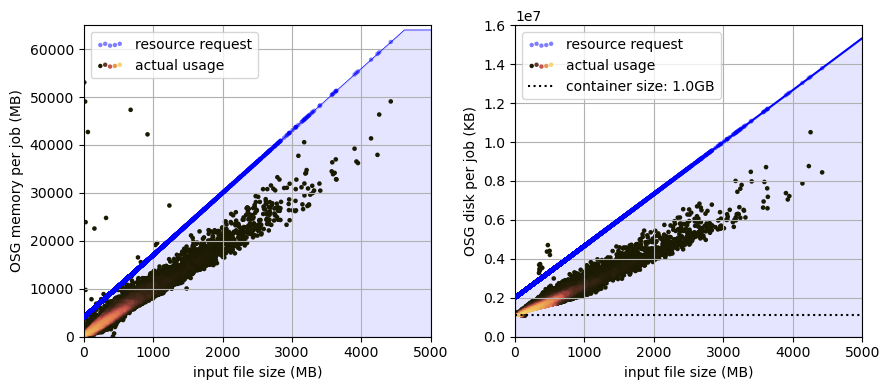

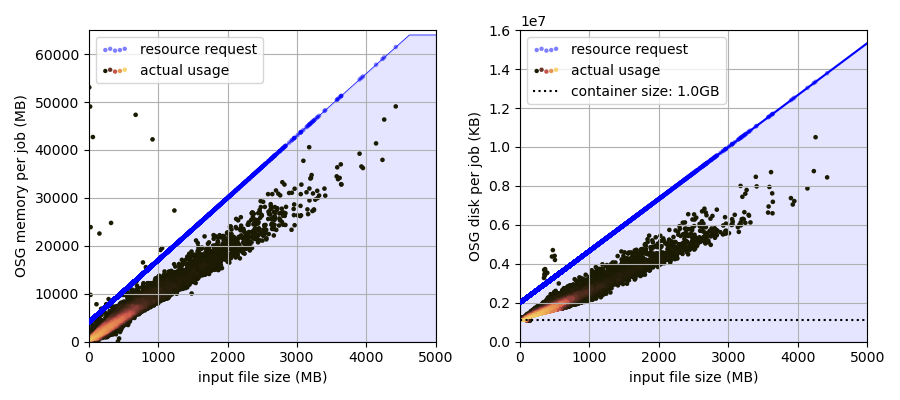

In [39]:
from sklearn.neighbors import KDTree
from cmcrameri import cm as cmc
nscatt = 5
v_max = 1.

plt.close('all')

def density_scatter(x, y, ax=None, sort=True, wid=0.1, K_pts=30, scattersize_min=1, scattersize_max=10, cmap=cmc.batlow, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """

    x = np.asarray(x)
    y = np.asarray(y)

    print('Plotting density scatter... ', end='')
    if ax is None :
        fig , ax = plt.subplots()
        xnorm = (x - np.nanmin(x)) /  (np.nanmax(x) - np.nanmin(x))
        ynorm = (y - np.nanmin(y)) /  (np.nanmax(y) - np.nanmin(y))
    else:
        minx, maxx = ax.get_xlim()
        miny, maxy = ax.get_ylim()
        xnorm = (x - minx) /  (maxx - minx)
        ynorm = (y - miny) /  (maxy - miny)

    # get density
    Xn = np.array(np.transpose(np.vstack((xnorm, ynorm))))
    kdt = KDTree(Xn)
    idx, dist = kdt.query_radius(Xn, r=wid, count_only=False, return_distance=True, sort_results=True)
    density = (np.array([np.sum(1-np.abs(x/wid)) if (len(x)<(K_pts+1)) 
               else np.sum(1-np.abs(x[:K_pts+1]/wid))
               for x in dist]) - 1) / K_pts

    #To be sure to plot all data
    density[np.where(np.isnan(density))] = 0.0
    density = density
    density /= np.nanmax(density)

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = density.argsort()
        x, y, density = x[idx], y[idx], density[idx]

    ax.scatter( x, y, c=density, s=(1-density)*scattersize_max+scattersize_min, cmap=cmap, **kwargs )

    print(' --> Done!')

    return ax

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(cmc.lajolla_r, minval=0.0, maxval=0.8, n=100)

dfs = pd.concat((
                 # pd.read_csv('resource_analysis/request_info_gld3test-GRE-CW-0.csv'), 
                 # pd.read_csv('resource_analysis/request_info_gld3test-GRE-NW-0.csv'),
                 pd.read_csv('resource_analysis/request_info_GLD3-GRE-0.csv'),
                 pd.read_csv('resource_analysis/request_info_GLD3-ANT_1-0.csv'),
                 pd.read_csv('resource_analysis/request_info_GLD3-ANT_2-0.csv'),
                 pd.read_csv('resource_analysis/request_info_GLD3-ANT_3-0.csv')
                )).reset_index(drop=True)

dfs['uniq'] = dfs.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfs = dfs.set_index('uniq')

dfm = pd.concat((
                 # pd.read_csv('resource_analysis/resource_stats_memory.csv', names=['raw']), 
                 # pd.read_csv('resource_analysis/resource_stats_memory2.csv', names=['raw']),
                 pd.read_csv('resource_analysis/resource_stats_memory_gris.csv', names=['raw']),
                 pd.read_csv('resource_analysis/resource_stats_memory_ais.csv', names=['raw']),
                )).reset_index(drop=True)

def get_used_mem(x):
    words = x.raw[x.raw.find('Memory (MB)          :')+22:].split()
    return int(words[0]) if len(words) == 3 else np.nan
    
dfm['descriptor'] = dfm.apply(lambda x: x.raw[9:x.raw[:x.raw.find('_ATL03_')].rfind('-')], axis=1)
dfm['granule_id'] = dfm.apply(lambda x: x.raw[x.raw.find('_ATL03_')+1:x.raw.rfind('-')], axis=1)
dfm['mem_used_mb'] = dfm.apply(get_used_mem, axis=1)
dfm['uniq'] = dfm.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfm = dfm.groupby('uniq')[['mem_used_mb']].max()
dfmm = dfs.join(dfm, how='left')

dfd = pd.concat((
                 # pd.read_csv('resource_analysis/resource_stats_disk.csv', names=['raw']), 
                 # pd.read_csv('resource_analysis/resource_stats_disk2.csv', names=['raw']),
                 pd.read_csv('resource_analysis/resource_stats_disk_gris.csv', names=['raw']),
                 pd.read_csv('resource_analysis/resource_stats_disk_ais.csv', names=['raw']),
                )).reset_index(drop=True)

def get_used_disk(x):
    words = x.raw[x.raw.find('Disk (KB)            :')+22:].split()
    return int(words[0]) if len(words) == 3 else np.nan
    
dfd['descriptor'] = dfd.apply(lambda x: x.raw[9:x.raw[:x.raw.find('_ATL03_')].rfind('-')], axis=1)
dfd['granule_id'] = dfd.apply(lambda x: x.raw[x.raw.find('_ATL03_')+1:x.raw.rfind('-')], axis=1)
dfd['disk_used_kb'] = dfd.apply(get_used_disk, axis=1)
dfd['uniq'] = dfd.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfd = dfd.groupby('uniq')[['disk_used_kb']].max()
dfdm = dfs.join(dfd, how='left')

def get_request_memory(x):
    req = 4000 + (30000-4000) / 2000 * x
    return int(np.ceil(np.clip(req, 0, 64000)))

def get_request_disk(x):
    req = 2e6 + (6e6-2e6) / 1500 * x
    return int(np.ceil(np.clip(req, 0, 32e6)))
    
dfmm['req_mem'] = dfmm.size_mb.apply(get_request_memory)
dfdm['req_dsk'] = dfdm.size_mb.apply(get_request_disk)

fig, axs = plt.subplots(ncols=2, figsize=[9,4])

xvals = np.linspace(0, np.max((5000, dfs.size_mb.max())), 500)
req_mem = [get_request_memory(x) for x in xvals]
req_disk = [get_request_disk(x) for x in xvals]

ax = axs[0]
ax.set_xlim((0, np.max(xvals)))
ax.set_ylim((0,65000))
ax.fill_between(xvals, req_mem, color='b', alpha=0.1)
ax.plot(xvals, req_mem, color='b', lw=0.5)
ax.scatter(dfmm.size_mb, dfmm.req_mem, s=10, color='b', edgecolors='none', alpha=0.5, label='resource request',zorder=1000)
density_scatter(dfmm.size_mb, dfmm.mem_used_mb, ax=ax, wid=0.003, K_pts=100, edgecolors='none', alpha=1, cmap=cmap, vmin=0, vmax=v_max,
                scattersize_min=1, scattersize_max=10)
# ax.scatter(dfmm.size_mb, dfmm.mem_used_mb, s=2, c=z, edgecolors='none', alpha=1, cmap=cmc.batlow)
ax.scatter([-9999]*nscatt, [-9999]*nscatt, s=10, c=cmap(np.linspace(0, 1/v_max, nscatt)), edgecolors='none', alpha=1, label='actual usage')
ax.grid()
ax.set_xlabel('input file size (MB)')
ax.set_ylabel('OSG memory per job (MB)')
ax.legend(loc='upper left', scatterpoints=nscatt)

ax = axs[1]
ax.set_xlim((0, np.max(xvals)))
ax.set_ylim((0,16e6))
ax.fill_between(xvals, req_disk, color='b', alpha=0.1)
ax.plot(xvals, req_disk, color='b')
ax.scatter(dfdm.size_mb, dfdm.req_dsk, s=10, color='b', edgecolors='none', alpha=0.5, label='resource request',zorder=1000)
# ax.scatter(dfdm.size_mb, dfdm.disk_used_kb, s=2, color='k', edgecolors='none', alpha=1)
density_scatter(dfmm.size_mb, dfdm.disk_used_kb, ax=ax, wid=0.003, K_pts=100, edgecolors='none', alpha=1, cmap=cmap, vmin=0, vmax=v_max,
                scattersize_min=1, scattersize_max=10)
ax.scatter([-9999]*nscatt, [-9999]*nscatt, s=10, c=cmap(np.linspace(0, 1/v_max, nscatt)), edgecolors='none', alpha=1, label='actual usage')
ax.grid(zorder=-100)
ax.set_xlabel('input file size (MB)')
ax.set_ylabel('OSG disk per job (KB)')

sif_fn = 'singularity_container/icelake-container_v1.sif'
sif_size = os.path.getsize(sif_fn)
sif_size_kb = sif_size / 1024
sif_size_gb = sif_size_kb / 1024**2
ax.axhline(sif_size_kb, color='k', linestyle=':', label='container size: %.1fGB' % sif_size_gb) 

ax.legend(loc='upper left', scatterpoints=nscatt)

fig.tight_layout()
fig.savefig('resource_analysis/resource-usage_plots.jpg',dpi=300)
display(fig)